## Dacon_AISR (Colab Demo)
---


**File Structure**


```
./Dacon_SR
├── inputs
│   ├── train
|   |   ├── hr
│   │   |   ├── 0000.png
│   │   |   ├── 0001.png
│   │   |   ├── 0002.png
|   |   |    ...
│   │   ├── lr
|   |       ├── 0000.png
|   |       ├── 0001.png
|   |       ├── 0002.png
|   |        ...
│   ├── test
│   │   ├── 20000.png
│   │   ├── 20001.png
│   │   ├── ...
├── tags
├── ...
├── weight
│   ├── net_g_905000.pth
```

Data는 inputs 폴더 안에<br>
weight는 weight 폴더 안에 넣어줌

In [1]:
!nvidia-smi ## check GPU allocation

Mon Dec  5 07:27:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## mount google drive

from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/VisionAI/Dacon_SR

Mounted at /content/drive
/content/drive/MyDrive/VisionAI/Dacon_SR


### 패키지 로드

In [3]:
# Load the package you are going to use
import torch
from torch.autograd import Variable
from PIL import Image
import numpy as np
import time, math
import matplotlib.pyplot as plt
%matplotlib inline

### Installation

Install dependent packages

In [4]:
# Install basicsr - https://github.com/xinntao/BasicSR
# We use BasicSR for both training and inference
!pip install basicsr
# facexlib and gfpgan are for face enhancement
!pip install facexlib
!pip install gdown
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 172 kB 4.0 MB/s 
     |████████████████████████████████| 5.7 MB 60.8 MB/s 
     |████████████████████████████████| 190 kB 91.4 MB/s 
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214839 sha256=55385cb929b0efab195817a5e22260054b87ee158affde02c763d9f4d47a29eb
  Stored in directory: /root/.cache/pip/wheels/4d/d3/95/e17d0bcdd7dcfb0dbf79db006711e434c42036efbf6695ef7f
Successfully built basicsr
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 2.9 MB/s 
     |████████████████████████████████| 177 kB 8.1 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=9ed364dcd23991e269c103b79bc58db751262b0261c9b79342d6a3fb6f79fadb
  Stored in directory: /root/.cache/pip/wheels/fe/f6/cb/40331472edf4fd399b

### Running Code

Inference

In [5]:
!python inference_rrdbnetrot.py --model_path=./weights/net_g_905000.pth --input=./inputs/test/lr --suffix=''

RRDBNetRot(
  (conv_first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (body): Sequential(
    (0): RRDB(
      (rdb1): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv5): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (rdb2): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1

## Metric Functions

In [6]:
# Peak Signal-to-Noise Ratio (PSNR)
def psnr(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = np.sqrt(np.mean(diff ** 2.))
    
    return 20 * np.log10(255. / rmse)

In [7]:
# Mean Squared Error (MSE)
def mse(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)
    
    err /= np.float(target_data.shape[0] * target_data.shape[1])
    return err

In [8]:
# SSIM
from skimage.metrics import structural_similarity as ssim

In [9]:
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))
    return scores

### Visualization

In [10]:
im_b = Image.open("inputs/test/lr/20000.png")
im_h = Image.open("results/20000.png")

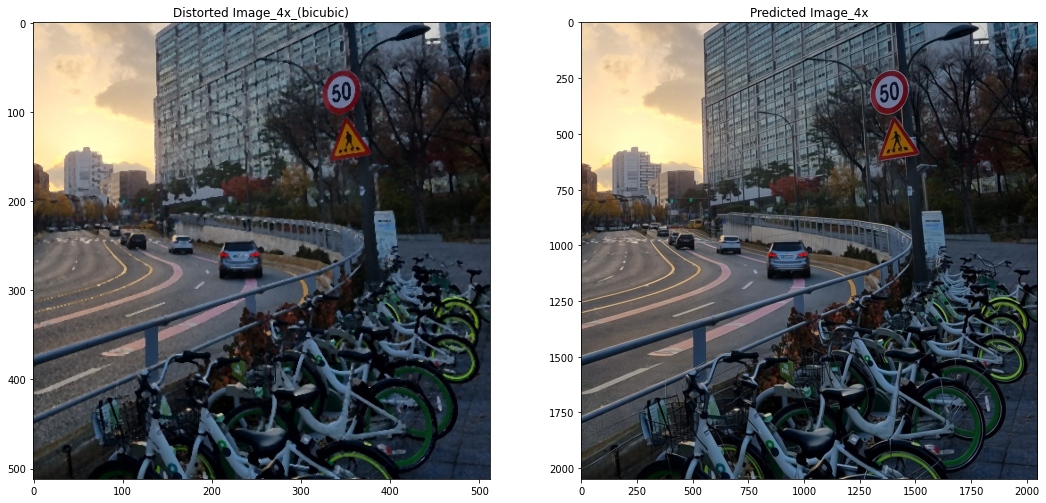

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18, 16))
ax[0].imshow(im_b)
ax[0].title.set_text("Distorted Image_4x_(bicubic)")

ax[1].imshow(im_h)
ax[1].title.set_text("Predicted Image_4x")

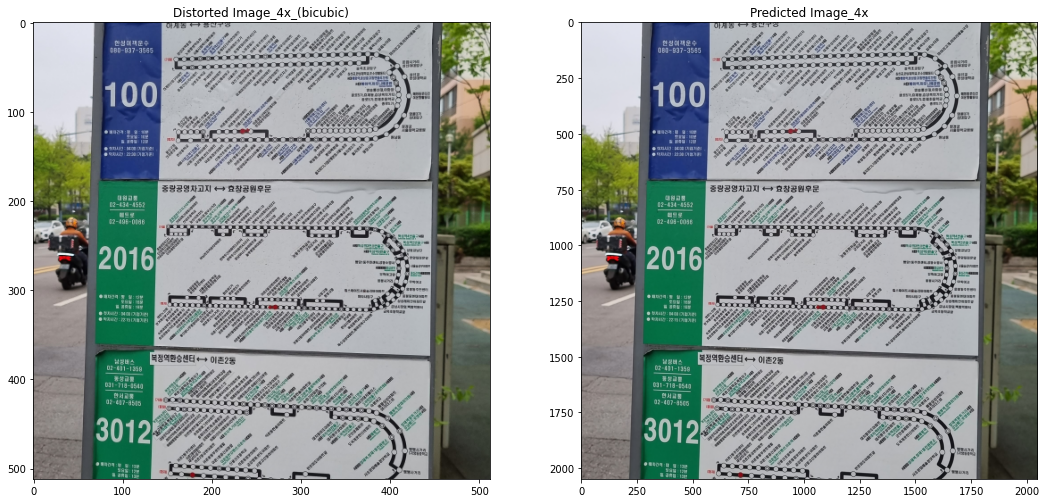

In [12]:
im_b = Image.open("inputs/test/lr/20008.png")
im_h = Image.open("results/20008.png")
fig, ax = plt.subplots(1, 2, figsize=(18, 16))
ax[0].imshow(im_b)
ax[0].title.set_text("Distorted Image_4x_(bicubic)")

ax[1].imshow(im_h)
ax[1].title.set_text("Predicted Image_4x")

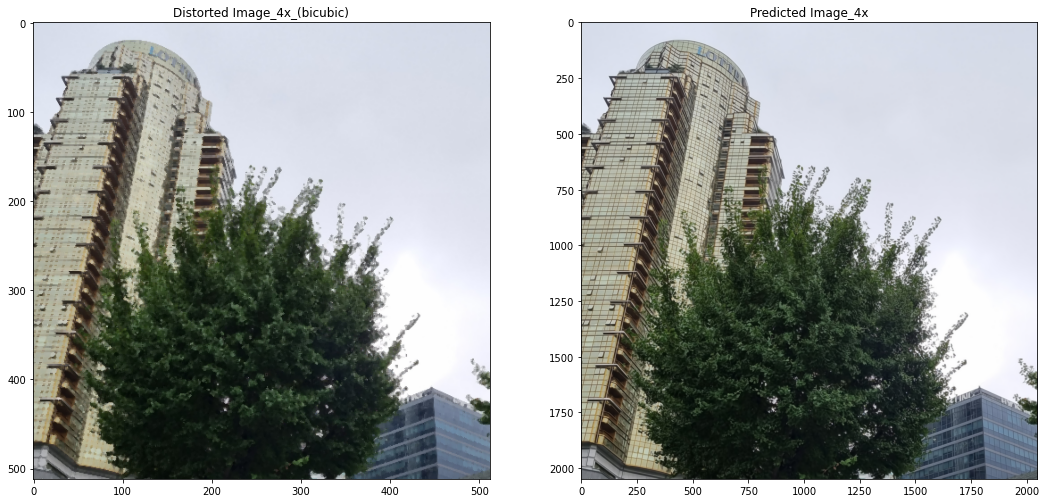

In [13]:
im_b = Image.open("inputs/test/lr/20015.png")
im_h = Image.open("results/20015.png")
fig, ax = plt.subplots(1, 2, figsize=(18, 16))
ax[0].imshow(im_b)
ax[0].title.set_text("Distorted Image_4x_(bicubic)")

ax[1].imshow(im_h)
ax[1].title.set_text("Predicted Image_4x")

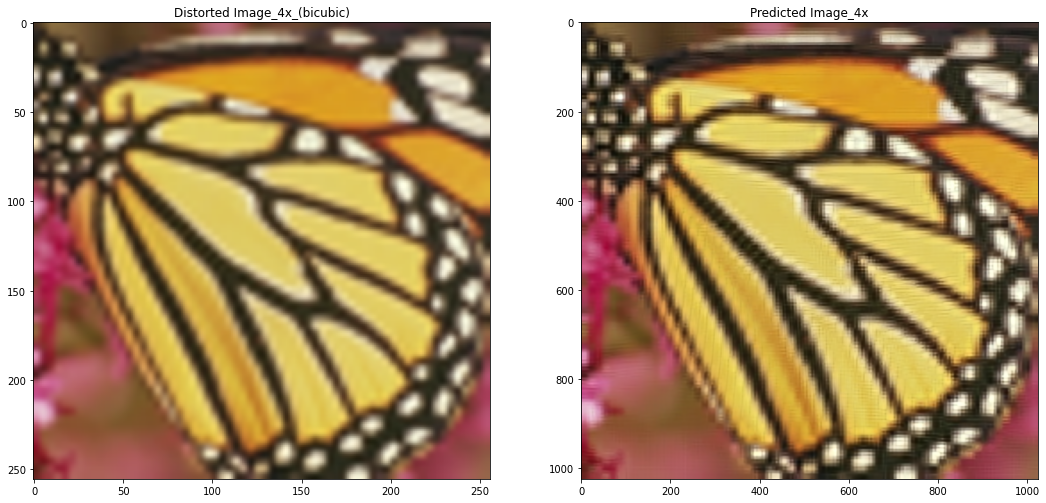

In [14]:
im_b = Image.open("inputs/test/lr/butterfly_GT_scale_4.bmp")
im_h = Image.open("results/butterfly_GT_scale_4.bmp")
fig, ax = plt.subplots(1, 2, figsize=(18, 16))
ax[0].imshow(im_b)
ax[0].title.set_text("Distorted Image_4x_(bicubic)")

ax[1].imshow(im_h)
ax[1].title.set_text("Predicted Image_4x")

# 결과

## 1. 원본 이미지 데이터가 제공되지 않아 PSNR 등 평가 산식은 계산이 불가합니다.
## 2. 총 18개의 테스트 이미지 중에 해상도 비교가 쉬운 3개의 이미지만 출력하여 비교하였습니다.
## 3. 지난 2개의 모델에서 사용했던 나비 이미지는 비교를 위해 추가한 것으로 4배 왜곡 이미지를 테스트 이미지로 사용하였으나 다른 이미지에 비해 해상도가 많이 떨어지는데, 이유를 모르겠습니다.  

## 4. 로우이미지는 'input/test/lr/' 폴더에 있으며 초해상화 결과 이미지는 'results' 폴더에 4개씩 있습니다. 다운로드 받아서 확대해서 비교하시면 차이가 엄청 나네요...  PPT 자료 작업 하실때 이미지 다운 받아서 특정 부분 크롭해서 비교 하시는게 설명하시기 수월할듯 합니다.